In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import os
import sys
#list the current working dir
os.getcwd()
#change the current working dir
os.chdir('/content/drive/MyDrive/sentiment_classsification/')

In [9]:
pwd

'/content/drive/MyDrive/sentiment_classsification'

Implementation of LSTM

In [ ]:
import torch
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import torch.optim as opt
import torch.nn as nn
import seaborn as sns
import string
import re
import nltk
from nltk.corpus import stopwords 
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
%matplotlib inline
nltk.download('stopwords')

In [11]:
data_file_path = './yadr_chunks.csv'
df = pd.read_csv(data_file_path)
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0.0,0.0,0.0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1.0,0.0,1.0,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0.0,0.0,0.0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1.0,0.0,1.0,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1.0,0.0,1.0,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [12]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [91]:
# Function to map stars to sentiment
def map_sentiment(stars_received):
    if stars_received <= 3:
        return 0 #negative
    else:
        return 1 #positive

In [92]:
print("Columns in the original dataset:\n")
print(df.columns)
# Mapping stars to sentiment into three categories
df['sentiment'] = [ map_sentiment(x) for x in df['stars']]

Columns in the original dataset:

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date', 'sentiment'],
      dtype='object')


In [93]:
X,y = df['text'].values,df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (5242711,)
shape of test data is (1747571,)


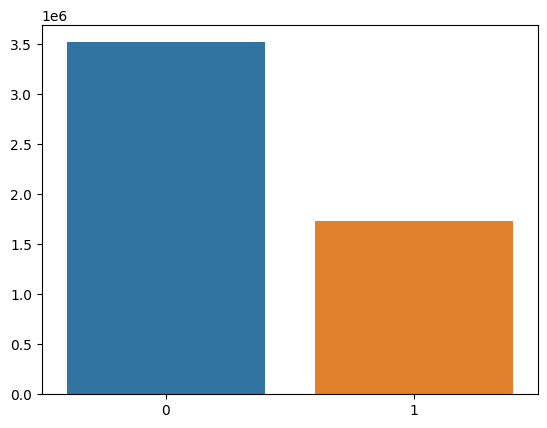

In [94]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['0','1']),y=dd.values)
plt.show()

In [96]:
# Function to retrieve top few number of each category - to avoid the imbalance classes issue
def get_top_data(top_data_df, top_n = 5000):
    top_data_df_positive = top_data_df[top_data_df['sentiment'] == 1].head(top_n)
    top_data_df_negative = top_data_df[top_data_df['sentiment'] == 0].head(top_n)
  #  top_data_df_neutral = top_data_df[top_data_df['sentiment'] == 1].head(top_n)
    top_data_df_small = pd.concat([top_data_df_positive, top_data_df_negative])
    return top_data_df_small

In [97]:
# Function call to get the top 10000 from each sentiment
top_data_df_small = get_top_data(df, top_n=42000)

In [157]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tockenize(x_train,y_train,x_test, y_test,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)#[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train, final_list_test, final_list_val= [],[],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_test:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_val.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])

    return np.array(final_list_train), np.array(y_train),np.array(final_list_test), np.array(y_test), np.array(final_list_val), np.array(y_val),onehot_dict

In [158]:
X,y = top_data_df_small['text'].values,top_data_df_small['sentiment'].values
x_train, x_test, y_train, y_test = train_test_split(top_data_df_small['text'], 
                                                        top_data_df_small['sentiment'], 
                                                        shuffle=True,
                                                        test_size=0.2, 
                                                        random_state=35)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=35)
print(f'shape of val data is {x_val.shape}')
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of val data is (16800,)
shape of train data is (50400,)
shape of test data is (16800,)


In [159]:
x_train,y_train,x_test,y_test,x_val, y_val, vocab = tockenize(x_train,y_train,x_test,y_test, x_val, y_val)

<ipython-input-157-07b7e91d3c0d>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(final_list_train), np.array(y_train),np.array(final_list_test), np.array(y_test), np.array(final_list_val), np.array(y_val),onehot_dict


In [160]:
print(x_train[0:10])
print(y_train[0:10])
print(x_test[0:10])
print(y_test[0:10])
print(x_val[0:10])
print(y_val[0:10])
print(f'Length of vocabulary is {len(vocab)}')


[list([243, 32, 607, 258, 121, 869, 181, 35, 5, 81, 71, 889, 9, 101, 207, 157, 1852, 14, 31101, 199, 540, 5958, 308, 1, 617, 16, 1704, 319, 29, 75, 7907, 38, 568, 484, 4020, 4353, 80, 1628, 161, 10, 31, 49, 11])
 list([28, 854, 3, 75, 2766, 23931, 2378, 34, 17726, 34, 818, 17, 712])
 list([304, 139, 370, 1612, 158, 452, 113, 644, 341, 8380, 1935, 499, 50, 8, 2340, 917, 20170, 6, 23932, 41])
 list([176, 413, 96, 1141, 1231, 222, 4398, 27, 30, 2745, 275, 47, 38, 31102, 315, 4398, 195, 1, 23, 20, 76, 175, 152, 20, 100, 329, 78, 172, 183, 965, 11996, 31103, 196, 31, 12, 11, 2603, 491, 252, 143, 20, 1769, 67, 106, 2481, 244, 55, 9, 663, 190, 444, 332, 20, 1673, 1791, 27])
 list([79, 270, 39, 85, 3, 42, 635, 341, 413, 1967, 25, 313, 130, 36, 5, 140, 6, 2911, 2417, 189, 1802, 113, 177, 8, 113, 17727, 40, 77, 38, 43, 105, 177, 47, 17, 49, 655, 18, 4182, 271, 48, 115, 717, 1453, 114, 28, 298, 450, 89, 114, 115, 164, 44, 77, 2418, 17728, 11])
 list([13, 403, 221, 5591, 12699, 570, 2671, 115, 147

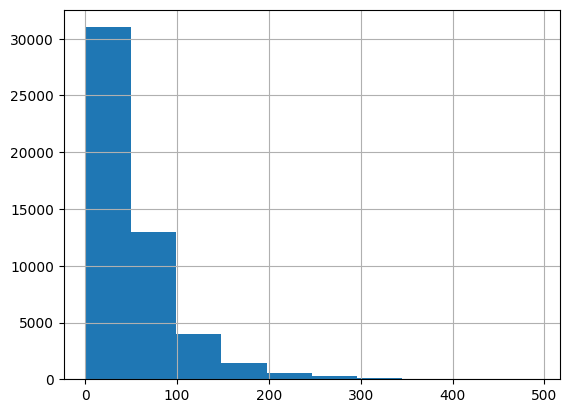

count    50400.000000
mean        54.342917
std         48.404438
min          1.000000
25%         23.000000
50%         40.000000
75%         69.000000
max        492.000000
dtype: float64

In [161]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [162]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features


In [163]:
#we have very less number of reviews with length > 400.
#So we will consideronly those below it.
x_train_pad = padding_(x_train,400)
x_val_pad = padding_(x_val, 400)
x_test_pad = padding_(x_test,400)

In [164]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_val_pad), torch.from_numpy(y_val))
test_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))
# dataloaders
batch_size = 50
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [165]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 400])
Sample input: 
 tensor([[    0,     0,     0,  ...,  2353,   148,   105],
        [    0,     0,     0,  ...,    93,   274,   135],
        [  973,    13,    44,  ...,   356, 26824,    73],
        ...,
        [    0,     0,     0,  ...,  4511,    41,  2362],
        [    0,     0,     0,  ...,    33,    38,  2250],
        [    0,     0,     0,  ...,    98,   183,  2418]])
Sample input: 
 tensor([0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
        0, 1])


In [166]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 400, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden


In [167]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 500
output_dim = 1
hidden_dim = 256
model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(66889, 500)
  (lstm): LSTM(500, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [168]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [169]:
clip = 5
epochs = 5 
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    start_time = time.time()
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1} Time Taken {time.time() - start_time}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), './state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

Epoch 1 Time Taken 90.38582968711853
train_loss : 0.398392503866778 val_loss : 0.3149788530898236
train_accuracy : 82.43055555555556 val_accuracy : 86.60714285714286
Validation loss decreased (inf --> 0.314979).  Saving model ...
Epoch 2 Time Taken 93.81692361831665
train_loss : 0.2535501132305298 val_loss : 0.289605918916918
train_accuracy : 89.57142857142857 val_accuracy : 88.01190476190476
Validation loss decreased (0.314979 --> 0.289606).  Saving model ...
Epoch 3 Time Taken 95.82317352294922
train_loss : 0.16747978178503375 val_loss : 0.3246419028201628
train_accuracy : 93.40277777777779 val_accuracy : 87.36904761904762
Epoch 4 Time Taken 96.50975370407104
train_loss : 0.09050265499686319 val_loss : 0.398852431991448
train_accuracy : 96.60317460317461 val_accuracy : 86.55357142857143
Epoch 5 Time Taken 96.84562110900879
train_loss : 0.04357699928865288 val_loss : 0.5320287770868856
train_accuracy : 98.45833333333334 val_accuracy : 86.50595238095238


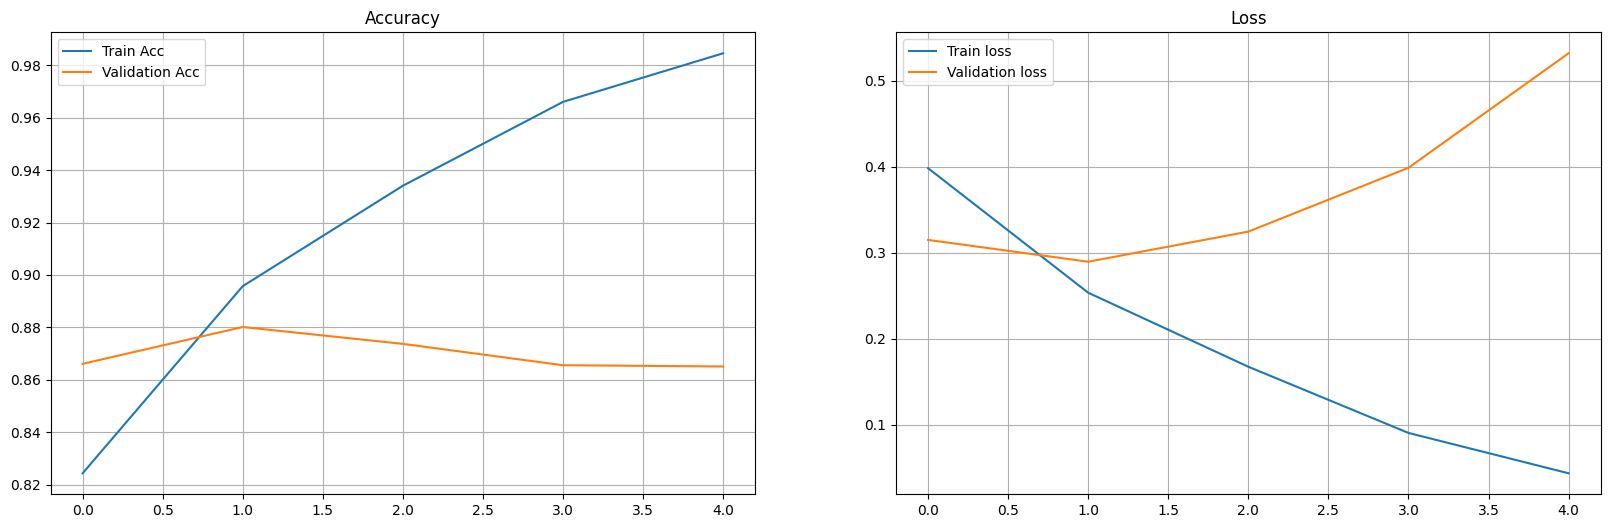

In [170]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [174]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = model.init_hidden(batch_size)

model.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    
    inputs, labels = inputs.to(device), labels.to(device)
    
    # get predicted outputs
    output, h = model(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy()) #if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.536
Test accuracy: 0.866


In [175]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

In [177]:
index = 45000
print(df['text'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['text'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

I've worked with A Classic on several parties now and have to say, despite not liking the prices of table, chair, etc. rentals (their prices are pretty standard), I do appreciate the professionalism and organization of this business. I love knowing that I can pull up to the bay and fill/unload my car within 5-10 minutes and be on the road again. *Expect to pay $1+ per chair rental - they offer around 9 varieties.  You'll also find everything from table decor to tablecloths and everything in between.
Actual sentiment is  : 1
Predicted sentiment is positive with a probability of 0.9629965424537659


Run for CNN

In [ ]:
%run training_testing.py

Loading saved Model for testing

In [ ]:
import torch
import time
import pandas as pd
import torch.optim as opt
from dataset import *
from cnn_model import *
from sklearn.metrics import classification_reportsification_report
import training_testing

PATH="cnn_big_model_500_with_padding.pth"
cnn_model = torch.load(PATH)
cnn_model.eval()